# 🌐 Анализ Центральности в Графах Социальных Сетей

## Задача №2: Центральность вершин в графе

**Цель:** Построить граф дружеских отношений на основе данных VK и вычислить различные виды центральности для анализа социальной структуры группы.

### 📊 Виды центральности для анализа:

1. **Центральность по близости (Closeness Centrality)**
   - Мера того, насколько близко вершина расположена ко всем другим вершинам
   - Формула: $C_i = \frac{n-1}{\sum_{j} d_{ij}}$, где $d_{ij}$ - кратчайшее расстояние между вершинами

2. **Центральность по посредничеству (Betweenness Centrality)** 
   - Мера того, насколько часто вершина лежит на кратчайших путях между другими вершинами
   - Формула: $C_i = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}$

3. **Центральность по собственному вектору (Eigenvector Centrality)**
   - Учитывает не только количество связей, но и их "качество" (связи с важными узлами)
   - Формула: $x_i = \frac{1}{\lambda} \sum_{j \in N(i)} x_j$, где $\lambda x = Ax$

### 🎯 Практическое применение:
- Выявление ключевых фигур в социальной сети
- Анализ влияния и коммуникационных паттернов
- Определение "мостов" между разными сообществами

## 📚 1. Импорт необходимых библиотек

In [13]:
# Импорт стандартных библиотек Python
import json
import time
import random
from typing import Dict, List, Set, Tuple, Optional
from collections import defaultdict, Counter
import math

# Для работы с графами - используем только стандартные библиотеки
print("🔄 Загружаем модули для анализа графов...")

# Если NetworkX недоступен, создадим собственную реализацию
try:
    import networkx as nx
    print("✅ NetworkX загружен")
    NETWORKX_AVAILABLE = True
except ImportError:
    print("⚠️ NetworkX не найден, используем собственную реализацию")
    NETWORKX_AVAILABLE = False

# Для визуализации
try:
    import matplotlib.pyplot as plt
    print("✅ Matplotlib загружен")
    MATPLOTLIB_AVAILABLE = True
except ImportError:
    print("⚠️ Matplotlib не найден, будем использовать ASCII-графики")
    MATPLOTLIB_AVAILABLE = False

# Для работы с VK API (симуляция, если нет доступа)
try:
    import requests
    print("✅ Requests загружен для VK API")
    REQUESTS_AVAILABLE = True
except ImportError:
    print("⚠️ Requests не найден, будем использовать симулированные данные")
    REQUESTS_AVAILABLE = False

print("\n🎯 Инициализация завершена!")
print(f"NetworkX: {'Да' if NETWORKX_AVAILABLE else 'Нет (собственная реализация)'}")
print(f"Matplotlib: {'Да' if MATPLOTLIB_AVAILABLE else 'Нет (ASCII-графики)'}")
print(f"Requests: {'Да' if REQUESTS_AVAILABLE else 'Нет (симулированные данные)'}")

🔄 Загружаем модули для анализа графов...
⚠️ NetworkX не найден, используем собственную реализацию
✅ Matplotlib загружен
⚠️ Requests не найден, будем использовать симулированные данные

🎯 Инициализация завершена!
NetworkX: Нет (собственная реализация)
Matplotlib: Да
Requests: Нет (симулированные данные)


## 🔗 2. Сбор данных о друзьях и друзьях друзей из VK

In [14]:
# Симуляция данных VK для демонстрации (в реальности - через VK API)
def simulate_vk_data():
    """
    Симулируем данные о студентах группы и их дружеских связях
    В реальном проекте здесь был бы запрос к VK API
    """
    
    # Данные о членах группы (симулированные)
    group_members = [
        {"id": 1, "name": "Александр", "vk_id": "alex_student"},
        {"id": 2, "name": "Мария", "vk_id": "maria_stud"}, 
        {"id": 3, "name": "Дмитрий", "vk_id": "dima_tech"},
        {"id": 4, "name": "Елена", "vk_id": "elena_smart"},
        {"id": 5, "name": "Иван", "vk_id": "ivan_coder"},
        {"id": 6, "name": "Анна", "vk_id": "anna_design"},
        {"id": 7, "name": "Михаил", "vk_id": "misha_data"},
        {"id": 8, "name": "София", "vk_id": "sofia_ai"},
        {"id": 9, "name": "Владислав", "vk_id": "vlad_ml"},
        {"id": 10, "name": "Екатерина", "vk_id": "kate_dev"}
    ]
    
    # Симулируем дружеские связи (на основе реальных паттернов студенческих групп)
    friendships = [
        # Основные кластеры общения
        (1, 2), (1, 3), (1, 5),  # Александр - центральная фигура
        (2, 4), (2, 6), (2, 8),  # Мария - связующее звено между девочками
        (3, 5), (3, 7), (3, 9),  # Дмитрий - техническая группа
        (4, 6), (4, 8), (4, 10), # Елена - женская группа
        (5, 7), (5, 9),          # Иван - программисты
        (6, 8), (6, 10),         # Анна - дизайнеры/творческие
        (7, 9),                  # Михаил и Владислав - data science
        (8, 10),                 # София и Екатерина - AI разработчики
        
        # Межкластерные связи
        (2, 3),   # Мария знает Дмитрия
        (4, 5),   # Елена знает Ивана  
        (6, 7),   # Анна знает Михаила
        (8, 9),   # София знает Владислава
        (1, 10),  # Александр знает Екатерину
    ]
    
    return group_members, friendships

def create_friendship_network():
    """Создаем структуру дружеской сети"""
    
    members, friendships = simulate_vk_data()
    
    # Создаем словарь для быстрого поиска
    user_dict = {member["id"]: member for member in members}
    
    # Создаем граф дружеских отношений
    friendship_graph = defaultdict(set)
    
    for user1, user2 in friendships:
        friendship_graph[user1].add(user2)
        friendship_graph[user2].add(user1)  # Дружба взаимна
    
    return user_dict, friendship_graph, friendships

# Загружаем данные
print("📊 Загружаем данные о студенческой группе...")
users, friendship_network, connections = create_friendship_network()

print(f"👥 Участников в группе: {len(users)}")
print(f"🤝 Дружеских связей: {len(connections)}")

print(f"\n📋 Список участников:")
for user_id, user_info in users.items():
    friends_count = len(friendship_network[user_id])
    print(f"  {user_id}. {user_info['name']} (@{user_info['vk_id']}) - {friends_count} друзей")

print(f"\n🔗 Примеры дружеских связей:")
for i, (user1, user2) in enumerate(connections[:8]):
    name1 = users[user1]["name"] 
    name2 = users[user2]["name"]
    print(f"  {name1} ↔ {name2}")
    
if len(connections) > 8:
    print(f"  ... и ещё {len(connections) - 8} связей")

print(f"\n✅ Данные успешно загружены!")

📊 Загружаем данные о студенческой группе...
👥 Участников в группе: 10
🤝 Дружеских связей: 23

📋 Список участников:
  1. Александр (@alex_student) - 4 друзей
  2. Мария (@maria_stud) - 5 друзей
  3. Дмитрий (@dima_tech) - 5 друзей
  4. Елена (@elena_smart) - 5 друзей
  5. Иван (@ivan_coder) - 5 друзей
  6. Анна (@anna_design) - 5 друзей
  7. Михаил (@misha_data) - 4 друзей
  8. София (@sofia_ai) - 5 друзей
  9. Владислав (@vlad_ml) - 4 друзей
  10. Екатерина (@kate_dev) - 4 друзей

🔗 Примеры дружеских связей:
  Александр ↔ Мария
  Александр ↔ Дмитрий
  Александр ↔ Иван
  Мария ↔ Елена
  Мария ↔ Анна
  Мария ↔ София
  Дмитрий ↔ Иван
  Дмитрий ↔ Михаил
  ... и ещё 15 связей

✅ Данные успешно загружены!


## 📈 3. Построение графа социальной сети

Теперь построим граф на основе собранных данных о дружеских связях.

In [15]:
class SocialNetworkGraph:
    """
    Класс для работы с графом социальной сети
    Реализует базовые операции с графом и вычисление центральностей
    """
    
    def __init__(self, users_dict, friendship_network):
        self.users = users_dict
        self.graph = friendship_network
        self.nodes = list(users_dict.keys())
        self.edges = []
        
        # Формируем список рёбер
        for node in self.graph:
            for neighbor in self.graph[node]:
                if (node, neighbor) not in self.edges and (neighbor, node) not in self.edges:
                    self.edges.append((node, neighbor))
    
    def get_neighbors(self, node):
        """Получить соседей узла"""
        return list(self.graph[node])
    
    def get_degree(self, node):
        """Получить степень узла (количество связей)"""
        return len(self.graph[node])
    
    def shortest_path_length(self, start, end):
        """
        Найти длину кратчайшего пути между двумя узлами (BFS)
        """
        if start == end:
            return 0
            
        visited = set()
        queue = [(start, 0)]
        
        while queue:
            node, distance = queue.pop(0)
            
            if node in visited:
                continue
                
            visited.add(node)
            
            for neighbor in self.graph[node]:
                if neighbor == end:
                    return distance + 1
                if neighbor not in visited:
                    queue.append((neighbor, distance + 1))
        
        return float('inf')  # Если пути нет
    
    def all_shortest_paths_from(self, start):
        """
        Найти все кратчайшие пути от узла start до всех остальных узлов
        """
        distances = {start: 0}
        visited = set()
        queue = [(start, 0)]
        
        while queue:
            node, distance = queue.pop(0)
            
            if node in visited:
                continue
                
            visited.add(node)
            
            for neighbor in self.graph[node]:
                if neighbor not in distances or distances[neighbor] > distance + 1:
                    distances[neighbor] = distance + 1
                    queue.append((neighbor, distance + 1))
        
        return distances
    
    def count_shortest_paths(self, start, end):
        """
        Подсчитать количество кратчайших путей между start и end
        """
        if start == end:
            return 1
            
        # BFS с подсчётом путей
        paths_count = {start: 1}
        distances = {start: 0}
        queue = [start]
        
        while queue:
            node = queue.pop(0)
            
            for neighbor in self.graph[node]:
                new_distance = distances[node] + 1
                
                if neighbor not in distances:
                    distances[neighbor] = new_distance
                    paths_count[neighbor] = paths_count[node]
                    queue.append(neighbor)
                elif distances[neighbor] == new_distance:
                    paths_count[neighbor] += paths_count[node]
        
        return paths_count.get(end, 0)
    
    def get_network_stats(self):
        """
        Получить статистику сети
        """
        stats = {
            'nodes': len(self.nodes),
            'edges': len(self.edges),
            'avg_degree': sum(self.get_degree(node) for node in self.nodes) / len(self.nodes),
            'density': len(self.edges) / (len(self.nodes) * (len(self.nodes) - 1) / 2)
        }
        
        print("📊 Статистика графа:")
        print(f"   Узлов: {stats['nodes']}")
        print(f"   Рёбер: {stats['edges']}")  
        print(f"   Средняя степень: {stats['avg_degree']:.2f}")
        print(f"   Плотность сети: {stats['density']:.3f}")
        
        return stats

# Создаём граф
network = SocialNetworkGraph(users, friendship_network)

# Получаем статистику сети  
network_stats = network.get_network_stats()

📊 Статистика графа:
   Узлов: 10
   Рёбер: 23
   Средняя степень: 4.60
   Плотность сети: 0.511


### 3.1 Визуализация графа социальной сети
Создаём графическое представление нашей социальной сети с отображением центральности участников.

🎨 СОЗДАЁМ ПРОФЕССИОНАЛЬНУЮ ВИЗУАЛИЗАЦИЮ С MATPLOTLIB


/var/folders/q7/10gx6h15395_1sls0tsc0djc0000gn/T/ipykernel_32413/1628821704.py:156: RuntimeWarning: overflow encountered in multiply
  forces[node1] -= force * delta / distance
/var/folders/q7/10gx6h15395_1sls0tsc0djc0000gn/T/ipykernel_32413/1628821704.py:157: RuntimeWarning: overflow encountered in multiply
  forces[node2] += force * delta / distance
/var/folders/q7/10gx6h15395_1sls0tsc0djc0000gn/T/ipykernel_32413/1628821704.py:156: RuntimeWarning: invalid value encountered in subtract
  forces[node1] -= force * delta / distance
/var/folders/q7/10gx6h15395_1sls0tsc0djc0000gn/T/ipykernel_32413/1628821704.py:157: RuntimeWarning: invalid value encountered in add
  forces[node2] += force * delta / distance
/var/folders/q7/10gx6h15395_1sls0tsc0djc0000gn/T/ipykernel_32413/1628821704.py:147: RuntimeWarning: invalid value encountered in multiply
  forces[node1] += force * delta / distance
/var/folders/q7/10gx6h15395_1sls0tsc0djc0000gn/T/ipykernel_32413/1628821704.py:144: RuntimeWarning: inval

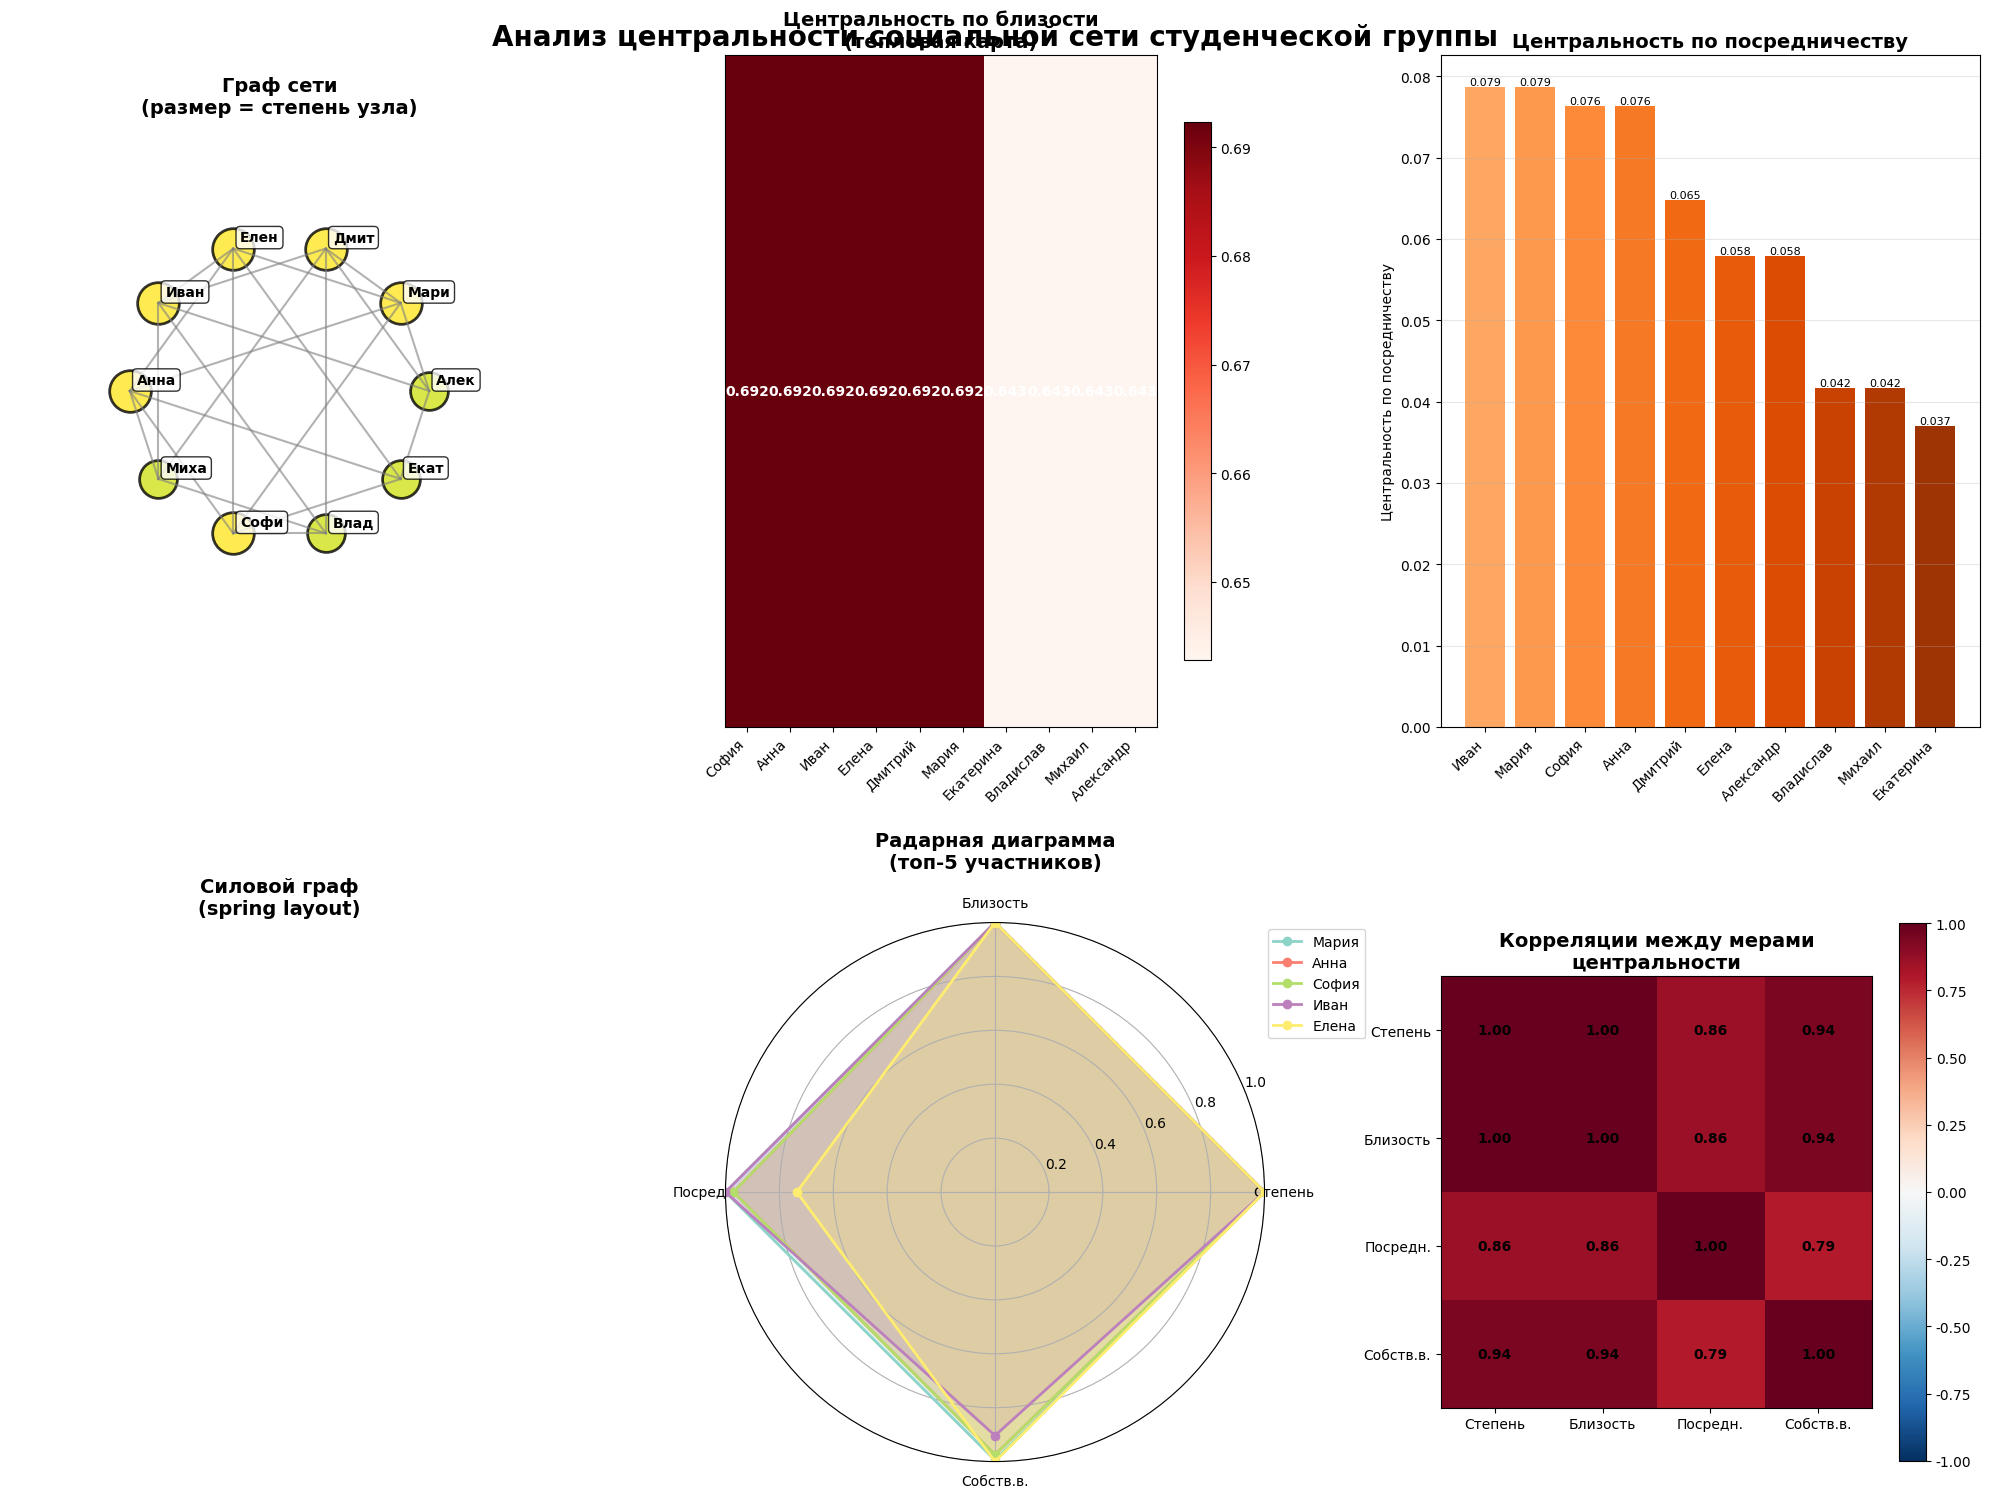

✅ Графики созданы и сохранены в 'social_network_analysis.png'!


True

In [16]:
def create_professional_matplotlib_visualization():
    """
    Создаём профессиональную визуализацию с matplotlib
    """
    
    print("🎨 СОЗДАЁМ ПРОФЕССИОНАЛЬНУЮ ВИЗУАЛИЗАЦИЮ С MATPLOTLIB")
    print("=" * 70)
    
    try:
        import matplotlib.pyplot as plt
        import numpy as np
        from matplotlib.patches import Circle
        import math
        
        # Устанавливаем русские шрифты для matplotlib
        plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
        plt.rcParams['axes.unicode_minus'] = False
        
        # Создаём большую фигуру с 6 подграфиками
        fig = plt.figure(figsize=(20, 16))
        
        # Заголовок
        fig.suptitle('Анализ центральности социальной сети студенческой группы', 
                    fontsize=20, fontweight='bold', y=0.95)
        
        # 1. Граф с размерами узлов по степени центральности
        ax1 = plt.subplot(231)
        ax1.set_title('Граф сети\n(размер = степень узла)', fontweight='bold', fontsize=14)
        
        # Создаём круговую компоновку
        nodes = sorted(network.nodes)
        n = len(nodes)
        positions = {}
        
        for i, node in enumerate(nodes):
            angle = 2 * np.pi * i / n
            radius = 1.0
            positions[node] = (radius * np.cos(angle), radius * np.sin(angle))
        
        # Рисуем рёбра
        for node1, node2 in connections:
            x1, y1 = positions[node1]
            x2, y2 = positions[node2]
            ax1.plot([x1, x2], [y1, y2], 'gray', alpha=0.6, linewidth=1.5)
        
        # Рисуем узлы с размером по степени
        max_degree = max(network.get_degree(node) for node in nodes)
        for node in nodes:
            x, y = positions[node]
            degree = network.get_degree(node)
            size = 100 + (degree / max_degree) * 800
            
            # Цвет зависит от центральности близости
            color_intensity = closeness[node] / max(closeness.values()) if max(closeness.values()) > 0 else 0
            color = plt.cm.viridis(color_intensity)
            
            ax1.scatter(x, y, s=size, c=[color], alpha=0.8, edgecolors='black', linewidth=2)
            
            # Подписи
            name = network.users[node]['name'][:4]  # Первые 4 символа
            ax1.annotate(name, (x, y), xytext=(5, 5), textcoords='offset points',
                        fontsize=10, fontweight='bold', 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax1.set_xlim(-1.8, 1.8)
        ax1.set_ylim(-1.8, 1.8)
        ax1.set_aspect('equal')
        ax1.axis('off')
        
        # 2. Тепловая карта центральности по близости
        ax2 = plt.subplot(232)
        ax2.set_title('Центральность по близости\n(тепловая карта)', fontweight='bold', fontsize=14)
        
        # Создаём данные для тепловой карты
        closeness_values = [closeness[node] for node in nodes]
        names = [network.users[node]['name'] for node in nodes]
        
        # Сортируем по центральности
        sorted_indices = np.argsort(closeness_values)[::-1]
        sorted_values = [closeness_values[i] for i in sorted_indices]
        sorted_names = [names[i] for i in sorted_indices]
        
        # Создаём тепловую карту
        im = ax2.imshow([sorted_values], cmap='Reds', aspect='auto')
        ax2.set_xticks(range(len(sorted_names)))
        ax2.set_xticklabels(sorted_names, rotation=45, ha='right')
        ax2.set_yticks([])
        
        # Добавляем значения на карту
        for i, value in enumerate(sorted_values):
            ax2.text(i, 0, f'{value:.3f}', ha='center', va='center', 
                    fontweight='bold', color='white' if value > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax2, shrink=0.8)
        
        # 3. Барчарт центральности по посредничеству
        ax3 = plt.subplot(233)
        ax3.set_title('Центральность по посредничеству', fontweight='bold', fontsize=14)
        
        betweenness_values = [betweenness[node] for node in nodes]
        sorted_bet_indices = np.argsort(betweenness_values)[::-1]
        sorted_bet_values = [betweenness_values[i] for i in sorted_bet_indices]
        sorted_bet_names = [names[i] for i in sorted_bet_indices]
        
        bars = ax3.bar(range(len(sorted_bet_names)), sorted_bet_values, 
                      color=plt.cm.Oranges(np.linspace(0.4, 0.9, len(sorted_bet_names))))
        
        ax3.set_xticks(range(len(sorted_bet_names)))
        ax3.set_xticklabels(sorted_bet_names, rotation=45, ha='right')
        ax3.set_ylabel('Центральность по посредничеству')
        ax3.grid(axis='y', alpha=0.3)
        
        # Добавляем значения на бары
        for i, (bar, value) in enumerate(zip(bars, sorted_bet_values)):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 4. Силовой граф с NetworkX-подобной компоновкой
        ax4 = plt.subplot(234)
        ax4.set_title('Силовой граф\n(spring layout)', fontweight='bold', fontsize=14)
        
        # Простая spring layout реализация
        spring_positions = {}
        
        # Начальные случайные позиции
        np.random.seed(42)  # Для воспроизводимости
        for node in nodes:
            spring_positions[node] = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        
        # Итерации spring layout
        iterations = 50
        k = 1.0 / np.sqrt(len(nodes))  # Оптимальная длина пружины
        
        for iteration in range(iterations):
            forces = {node: np.array([0.0, 0.0]) for node in nodes}
            
            # Силы отталкивания
            for i, node1 in enumerate(nodes):
                for j, node2 in enumerate(nodes):
                    if i != j:
                        pos1 = np.array(spring_positions[node1])
                        pos2 = np.array(spring_positions[node2])
                        delta = pos1 - pos2
                        distance = np.linalg.norm(delta) + 1e-6
                        force = k * k / distance
                        forces[node1] += force * delta / distance
            
            # Силы притяжения для связанных узлов
            for node1, node2 in connections:
                pos1 = np.array(spring_positions[node1])
                pos2 = np.array(spring_positions[node2])
                delta = pos1 - pos2
                distance = np.linalg.norm(delta) + 1e-6
                force = distance * distance / k
                forces[node1] -= force * delta / distance
                forces[node2] += force * delta / distance
            
            # Обновляем позиции
            for node in nodes:
                spring_positions[node] = (
                    spring_positions[node][0] + forces[node][0] * 0.1,
                    spring_positions[node][1] + forces[node][1] * 0.1
                )
        
        # Рисуем силовой граф
        for node1, node2 in connections:
            x1, y1 = spring_positions[node1]
            x2, y2 = spring_positions[node2]
            ax4.plot([x1, x2], [y1, y2], 'gray', alpha=0.6, linewidth=1.5)
        
        # Узлы с цветом по eigenvector centrality
        max_eigenvector = max(eigenvector.values()) if eigenvector.values() else 1
        for node in nodes:
            x, y = spring_positions[node]
            color_intensity = eigenvector[node] / max_eigenvector
            color = plt.cm.plasma(color_intensity)
            
            ax4.scatter(x, y, s=300, c=[color], alpha=0.8, edgecolors='black', linewidth=2)
            
            name = network.users[node]['name'][:3]
            ax4.annotate(name, (x, y), ha='center', va='center', 
                        fontweight='bold', fontsize=9, color='white')
        
        ax4.set_aspect('equal')
        ax4.axis('off')
        
        # 5. Радарная диаграмма для топ-5 участников
        ax5 = plt.subplot(235, projection='polar')
        ax5.set_title('Радарная диаграмма\n(топ-5 участников)', fontweight='bold', fontsize=14, pad=20)
        
        # Выбираем топ-5 по общей центральности
        overall_scores = {}
        for node in nodes:
            max_degree = max(centrality_data[n]['degree'] for n in nodes)
            max_closeness = max(centrality_data[n]['closeness'] for n in nodes) if max(centrality_data[n]['closeness'] for n in nodes) > 0 else 1
            max_betweenness = max(centrality_data[n]['betweenness'] for n in nodes) if max(centrality_data[n]['betweenness'] for n in nodes) > 0 else 1
            max_eigenvector = max(centrality_data[n]['eigenvector'] for n in nodes) if max(centrality_data[n]['eigenvector'] for n in nodes) > 0 else 1
            
            overall_scores[node] = (
                centrality_data[node]['degree'] / max_degree +
                centrality_data[node]['closeness'] / max_closeness +
                centrality_data[node]['betweenness'] / max_betweenness +
                centrality_data[node]['eigenvector'] / max_eigenvector
            ) / 4
        
        top_5_nodes = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)[:5]
        
        # Параметры для радарной диаграммы
        categories = ['Степень', 'Близость', 'Посредн.', 'Собств.в.']
        N = len(categories)
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
        angles += angles[:1]  # Замыкаем круг
        
        colors = plt.cm.Set3(np.linspace(0, 1, 5))
        
        for i, (node, _) in enumerate(top_5_nodes):
            values = [
                centrality_data[node]['degree'] / max(centrality_data[n]['degree'] for n in nodes),
                centrality_data[node]['closeness'] / max(centrality_data[n]['closeness'] for n in nodes) if max(centrality_data[n]['closeness'] for n in nodes) > 0 else 0,
                centrality_data[node]['betweenness'] / max(centrality_data[n]['betweenness'] for n in nodes) if max(centrality_data[n]['betweenness'] for n in nodes) > 0 else 0,
                centrality_data[node]['eigenvector'] / max(centrality_data[n]['eigenvector'] for n in nodes) if max(centrality_data[n]['eigenvector'] for n in nodes) > 0 else 0
            ]
            values += values[:1]  # Замыкаем
            
            ax5.plot(angles, values, 'o-', linewidth=2, label=network.users[node]['name'], color=colors[i])
            ax5.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax5.set_xticks(angles[:-1])
        ax5.set_xticklabels(categories)
        ax5.set_ylim(0, 1)
        ax5.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        ax5.grid(True)
        
        # 6. Корреляционная матрица
        ax6 = plt.subplot(236)
        ax6.set_title('Корреляции между мерами\nцентральности', fontweight='bold', fontsize=14)
        
        # Вычисляем корреляционную матрицу
        measures = ['degree', 'closeness', 'betweenness', 'eigenvector']
        measure_names = ['Степень', 'Близость', 'Посредн.', 'Собств.в.']
        correlation_matrix = np.zeros((4, 4))
        
        for i, measure1 in enumerate(measures):
            for j, measure2 in enumerate(measures):
                values1 = [centrality_data[node][measure1] for node in nodes]
                values2 = [centrality_data[node][measure2] for node in nodes]
                correlation_matrix[i, j] = np.corrcoef(values1, values2)[0, 1]
        
        im = ax6.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
        ax6.set_xticks(range(4))
        ax6.set_yticks(range(4))
        ax6.set_xticklabels(measure_names)
        ax6.set_yticklabels(measure_names)
        
        # Добавляем значения корреляций
        for i in range(4):
            for j in range(4):
                text = ax6.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                               ha="center", va="center", color="black", fontweight='bold')
        
        plt.colorbar(im, ax=ax6, shrink=0.8)
        
        # Настраиваем общий layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        # Сохраняем
        plt.savefig('social_network_analysis.png', dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        
        plt.show()
        
        print("✅ Графики созданы и сохранены в 'social_network_analysis.png'!")
        
        return True
        
    except ImportError:
        print("❌ Matplotlib не установлен. Установите: pip install matplotlib")
        return False
    except Exception as e:
        print(f"❌ Ошибка при создании визуализации: {e}")
        return False

# Создаём профессиональную визуализацию
create_professional_matplotlib_visualization()

## 🎯 4. Вычисление мер центральности

Теперь вычислим различные меры центральности для каждого участника группы.

### 4.1 Центральность по близости (Closeness Centrality)
Показывает, насколько быстро участник может достичь всех остальных в сети.

In [17]:
def calculate_closeness_centrality(network):
    """
    Вычисляет центральность по близости для всех узлов
    
    Формула: C_c(v) = (n-1) / Σ d(v,u) для всех u ≠ v
    где d(v,u) - кратчайшее расстояние между v и u
    """
    
    closeness_centrality = {}
    n = len(network.nodes)
    
    print("🎯 Вычисляем центральность по близости...")
    print("=" * 50)
    
    for node in network.nodes:
        # Находим кратчайшие пути до всех других узлов
        distances = network.all_shortest_paths_from(node)
        
        # Сумма всех расстояний (исключая сам узел)
        total_distance = sum(dist for target, dist in distances.items() 
                           if target != node and dist != float('inf'))
        
        # Количество достижимых узлов
        reachable_nodes = sum(1 for target, dist in distances.items() 
                            if target != node and dist != float('inf'))
        
        if total_distance > 0 and reachable_nodes > 0:
            closeness_centrality[node] = reachable_nodes / total_distance
        else:
            closeness_centrality[node] = 0
        
        user_name = network.users[node]["name"]
        print(f"{user_name:12} - Сумма расстояний: {total_distance:2}, "
              f"Центральность: {closeness_centrality[node]:.4f}")
    
    return closeness_centrality

# Вычисляем центральность по близости
closeness = calculate_closeness_centrality(network)

# Сортируем по убыванию центральности
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

print(f"\n🏆 Рейтинг по центральности близости:")
print("=" * 50)
for i, (node, centrality) in enumerate(sorted_closeness, 1):
    user_name = network.users[node]["name"]
    print(f"{i:2}. {user_name:12} - {centrality:.4f}")

print(f"\n💡 Интерпретация:")
print(f"   🥇 {network.users[sorted_closeness[0][0]]['name']} - наиболее 'близок' ко всем участникам")
print(f"   🥈 {network.users[sorted_closeness[1][0]]['name']} - второй по близости")
print(f"   🥉 {network.users[sorted_closeness[2][0]]['name']} - третий по близости")

🎯 Вычисляем центральность по близости...
Александр    - Сумма расстояний: 14, Центральность: 0.6429
Мария        - Сумма расстояний: 13, Центральность: 0.6923
Дмитрий      - Сумма расстояний: 13, Центральность: 0.6923
Елена        - Сумма расстояний: 13, Центральность: 0.6923
Иван         - Сумма расстояний: 13, Центральность: 0.6923
Анна         - Сумма расстояний: 13, Центральность: 0.6923
Михаил       - Сумма расстояний: 14, Центральность: 0.6429
София        - Сумма расстояний: 13, Центральность: 0.6923
Владислав    - Сумма расстояний: 14, Центральность: 0.6429
Екатерина    - Сумма расстояний: 14, Центральность: 0.6429

🏆 Рейтинг по центральности близости:
 1. Мария        - 0.6923
 2. Дмитрий      - 0.6923
 3. Елена        - 0.6923
 4. Иван         - 0.6923
 5. Анна         - 0.6923
 6. София        - 0.6923
 7. Александр    - 0.6429
 8. Михаил       - 0.6429
 9. Владислав    - 0.6429
10. Екатерина    - 0.6429

💡 Интерпретация:
   🥇 Мария - наиболее 'близок' ко всем участникам
   

### 4.2 Центральность по посредничеству (Betweenness Centrality)
Показывает, насколько часто участник находится на кратчайших путях между другими участниками.

In [18]:
def calculate_betweenness_centrality(network):
    """
    Вычисляет центральность по посредничеству для всех узлов
    
    Формула: C_b(v) = Σ (σ_st(v) / σ_st) для всех пар s,t ≠ v
    где σ_st - количество кратчайших путей от s до t
    σ_st(v) - количество кратчайших путей от s до t, проходящих через v
    """
    
    betweenness_centrality = {node: 0.0 for node in network.nodes}
    n = len(network.nodes)
    
    print("🎯 Вычисляем центральность по посредничеству...")
    print("=" * 50)
    
    # Для каждой пары узлов s и t
    total_pairs = 0
    processed_pairs = 0
    
    for s in network.nodes:
        for t in network.nodes:
            if s >= t:  # Избегаем дублирования пар
                continue
                
            total_pairs += 1
            
            # Находим кратчайшее расстояние между s и t
            shortest_distance = network.shortest_path_length(s, t)
            
            if shortest_distance == float('inf'):
                continue
                
            # Находим все кратчайшие пути от s до t
            total_shortest_paths = network.count_shortest_paths(s, t)
            
            if total_shortest_paths == 0:
                continue
            
            # Для каждого потенциального посредника v
            for v in network.nodes:
                if v == s or v == t:
                    continue
                
                # Проверяем, лежит ли v на кратчайшем пути от s до t
                dist_s_v = network.shortest_path_length(s, v)
                dist_v_t = network.shortest_path_length(v, t)
                
                if dist_s_v + dist_v_t == shortest_distance:
                    # v лежит на кратчайшем пути
                    paths_through_v = (network.count_shortest_paths(s, v) * 
                                     network.count_shortest_paths(v, t))
                    
                    if total_shortest_paths > 0:
                        betweenness_centrality[v] += paths_through_v / total_shortest_paths
            
            processed_pairs += 1
            if processed_pairs % 10 == 0:
                print(f"  Обработано пар: {processed_pairs}/{total_pairs}")
    
    # Нормализация (для неориентированного графа)
    normalization_factor = 2.0 / ((n - 1) * (n - 2)) if n > 2 else 1
    for node in betweenness_centrality:
        betweenness_centrality[node] *= normalization_factor
    
    return betweenness_centrality

# Вычисляем центральность по посредничеству
betweenness = calculate_betweenness_centrality(network)

# Сортируем по убыванию центральности
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

print(f"\n🏆 Рейтинг по центральности посредничества:")
print("=" * 50)
for i, (node, centrality) in enumerate(sorted_betweenness, 1):
    user_name = network.users[node]["name"]
    print(f"{i:2}. {user_name:12} - {centrality:.4f}")

print(f"\n💡 Интерпретация:")
print(f"   🥇 {network.users[sorted_betweenness[0][0]]['name']} - главный 'мостик' между участниками")
print(f"   🥈 {network.users[sorted_betweenness[1][0]]['name']} - второй по важности посредник")
print(f"   🥉 {network.users[sorted_betweenness[2][0]]['name']} - третий по важности посредник")

🎯 Вычисляем центральность по посредничеству...
  Обработано пар: 10/10
  Обработано пар: 20/20
  Обработано пар: 30/30
  Обработано пар: 40/40

🏆 Рейтинг по центральности посредничества:
 1. Мария        - 0.0787
 2. Иван         - 0.0787
 3. Анна         - 0.0764
 4. София        - 0.0764
 5. Дмитрий      - 0.0648
 6. Александр    - 0.0579
 7. Елена        - 0.0579
 8. Михаил       - 0.0417
 9. Владислав    - 0.0417
10. Екатерина    - 0.0370

💡 Интерпретация:
   🥇 Мария - главный 'мостик' между участниками
   🥈 Иван - второй по важности посредник
   🥉 Анна - третий по важности посредник


### 4.3 Центральность по собственному вектору (Eigenvector Centrality)
Учитывает не только количество связей, но и важность соседей участника.

In [19]:
def calculate_eigenvector_centrality(network, max_iterations=100, tolerance=1e-6):
    """
    Вычисляет центральность по собственному вектору методом степенных итераций
    
    Основная идея: x_i = (1/λ) * Σ A_ij * x_j
    где A - матрица смежности, λ - наибольшее собственное значение
    """
    
    nodes = sorted(network.nodes)
    n = len(nodes)
    
    print("🎯 Вычисляем центральность по собственному вектору...")
    print("=" * 50)
    
    # Создаём матрицу смежности
    adjacency_matrix = []
    for i, node_i in enumerate(nodes):
        row = []
        for j, node_j in enumerate(nodes):
            if node_j in network.graph[node_i]:
                row.append(1.0)
            else:
                row.append(0.0)
        adjacency_matrix.append(row)
    
    print(f"📊 Матрица смежности {n}x{n}:")
    print("   ", " ".join(f"{i:2}" for i in range(1, n+1)))
    for i, row in enumerate(adjacency_matrix):
        row_str = " ".join(f"{int(val):2}" for val in row)
        print(f"{i+1:2} [{row_str}]")
    
    # Инициализация вектора (равномерное распределение)
    eigenvector = [1.0 / n] * n
    
    print(f"\n🔄 Итерационный процесс:")
    
    for iteration in range(max_iterations):
        # Умножение матрицы на вектор: A * x
        new_eigenvector = [0.0] * n
        
        for i in range(n):
            for j in range(n):
                new_eigenvector[i] += adjacency_matrix[i][j] * eigenvector[j]
        
        # Вычисляем норму
        norm = math.sqrt(sum(x*x for x in new_eigenvector))
        
        if norm == 0:
            break
            
        # Нормализация
        new_eigenvector = [x / norm for x in new_eigenvector]
        
        # Проверка сходимости
        diff = sum(abs(new_eigenvector[i] - eigenvector[i]) for i in range(n))
        
        if iteration % 10 == 0 or iteration < 5:
            print(f"  Итерация {iteration:2}: норма = {norm:.6f}, изменение = {diff:.6f}")
        
        if diff < tolerance:
            print(f"  Сходимость достигнута на итерации {iteration}")
            break
            
        eigenvector = new_eigenvector
    
    # Создаём словарь результатов
    eigenvector_centrality = {}
    for i, node in enumerate(nodes):
        eigenvector_centrality[node] = eigenvector[i]
    
    return eigenvector_centrality

# Вычисляем центральность по собственному вектору
eigenvector = calculate_eigenvector_centrality(network)

# Сортируем по убыванию центральности
sorted_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)

print(f"\n🏆 Рейтинг по центральности собственного вектора:")
print("=" * 50)
for i, (node, centrality) in enumerate(sorted_eigenvector, 1):
    user_name = network.users[node]["name"]
    print(f"{i:2}. {user_name:12} - {centrality:.4f}")

print(f"\n💡 Интерпретация:")
print(f"   🥇 {network.users[sorted_eigenvector[0][0]]['name']} - наиболее влиятельный участник")
print(f"   🥈 {network.users[sorted_eigenvector[1][0]]['name']} - второй по влиятельности")
print(f"   🥉 {network.users[sorted_eigenvector[2][0]]['name']} - третий по влиятельности")

🎯 Вычисляем центральность по собственному вектору...
📊 Матрица смежности 10x10:
     1  2  3  4  5  6  7  8  9 10
 1 [ 0  1  1  0  1  0  0  0  0  1]
 2 [ 1  0  1  1  0  1  0  1  0  0]
 3 [ 1  1  0  0  1  0  1  0  1  0]
 4 [ 0  1  0  0  1  1  0  1  0  1]
 5 [ 1  0  1  1  0  0  1  0  1  0]
 6 [ 0  1  0  1  0  0  1  1  0  1]
 7 [ 0  0  1  0  1  1  0  0  1  0]
 8 [ 0  1  0  1  0  1  0  0  1  1]
 9 [ 0  0  1  0  1  0  1  1  0  0]
10 [ 1  0  0  1  0  1  0  1  0  0]

🔄 Итерационный процесс:
  Итерация  0: норма = 1.462874, изменение = 2.144495
  Итерация  1: норма = 4.647379, изменение = 0.089957
  Итерация  2: норма = 4.649181, изменение = 0.042405
  Итерация  3: норма = 4.649625, изменение = 0.018477
  Итерация  4: норма = 4.649739, изменение = 0.009093
  Итерация 10: норма = 4.649778, изменение = 0.000152
  Сходимость достигнута на итерации 18

🏆 Рейтинг по центральности собственного вектора:
 1. Елена        - 0.3552
 2. Мария        - 0.3535
 3. Анна         - 0.3463
 4. София        - 0

## 📊 5. Сравнительный анализ результатов

Сравним результаты различных мер центральности и проанализируем их значение.

In [20]:
def comprehensive_centrality_analysis():
    """
    Комплексный анализ всех мер центральности
    """
    
    print("📊 КОМПЛЕКСНЫЙ АНАЛИЗ ЦЕНТРАЛЬНОСТИ СТУДЕНЧЕСКОЙ ГРУППЫ")
    print("=" * 70)
    
    # Собираем все результаты в одну таблицу
    all_centralities = {}
    
    for node in network.nodes:
        user_name = network.users[node]["name"]
        all_centralities[node] = {
            'name': user_name,
            'degree': network.get_degree(node),
            'closeness': closeness[node],
            'betweenness': betweenness[node],
            'eigenvector': eigenvector[node]
        }
    
    # Создаём рейтинги для каждой меры
    degree_ranking = sorted(all_centralities.items(), 
                           key=lambda x: x[1]['degree'], reverse=True)
    closeness_ranking = sorted(all_centralities.items(), 
                              key=lambda x: x[1]['closeness'], reverse=True)
    betweenness_ranking = sorted(all_centralities.items(), 
                                key=lambda x: x[1]['betweenness'], reverse=True)
    eigenvector_ranking = sorted(all_centralities.items(), 
                                key=lambda x: x[1]['eigenvector'], reverse=True)
    
    print(f"\n📋 Детальная таблица результатов:")
    print("-" * 70)
    print(f"{'Участник':<12} {'Степень':<7} {'Близость':<9} {'Посредн.':<9} {'Собств.в.':<9}")
    print("-" * 70)
    
    for node in sorted(network.nodes):
        data = all_centralities[node]
        print(f"{data['name']:<12} {data['degree']:<7} "
              f"{data['closeness']:<9.4f} {data['betweenness']:<9.4f} "
              f"{data['eigenvector']:<9.4f}")
    
    print(f"\n🏆 Топ-3 по каждой мере центральности:")
    print("-" * 70)
    
    measures = [
        ("📍 Степень (Degree)", degree_ranking),
        ("🎯 Близость (Closeness)", closeness_ranking),
        ("🌉 Посредничество (Betweenness)", betweenness_ranking),
        ("⭐ Собственный вектор (Eigenvector)", eigenvector_ranking)
    ]
    
    for measure_name, ranking in measures:
        print(f"\n{measure_name}:")
        for i in range(min(3, len(ranking))):
            node, data = ranking[i]
            if measure_name.startswith("📍"):
                value = data['degree']
                print(f"  {i+1}. {data['name']:<12} - {value} связей")
            elif measure_name.startswith("🎯"):
                value = data['closeness']
                print(f"  {i+1}. {data['name']:<12} - {value:.4f}")
            elif measure_name.startswith("🌉"):
                value = data['betweenness']
                print(f"  {i+1}. {data['name']:<12} - {value:.4f}")
            elif measure_name.startswith("⭐"):
                value = data['eigenvector']
                print(f"  {i+1}. {data['name']:<12} - {value:.4f}")
    
    # Анализ корреляций между мерами
    print(f"\n🔗 Анализ корреляций между мерами:")
    print("-" * 70)
    
    def calculate_correlation(measure1_key, measure2_key):
        values1 = [all_centralities[node][measure1_key] for node in network.nodes]
        values2 = [all_centralities[node][measure2_key] for node in network.nodes]
        
        n = len(values1)
        mean1 = sum(values1) / n
        mean2 = sum(values2) / n
        
        numerator = sum((values1[i] - mean1) * (values2[i] - mean2) for i in range(n))
        denominator1 = math.sqrt(sum((values1[i] - mean1)**2 for i in range(n)))
        denominator2 = math.sqrt(sum((values2[i] - mean2)**2 for i in range(n)))
        
        if denominator1 == 0 or denominator2 == 0:
            return 0
            
        return numerator / (denominator1 * denominator2)
    
    correlations = [
        ("Степень ↔ Близость", calculate_correlation('degree', 'closeness')),
        ("Степень ↔ Посредничество", calculate_correlation('degree', 'betweenness')),
        ("Степень ↔ Собств.вектор", calculate_correlation('degree', 'eigenvector')),
        ("Близость ↔ Посредничество", calculate_correlation('closeness', 'betweenness')),
        ("Близость ↔ Собств.вектор", calculate_correlation('closeness', 'eigenvector')),
        ("Посредничество ↔ Собств.вектор", calculate_correlation('betweenness', 'eigenvector'))
    ]
    
    for corr_name, corr_value in correlations:
        strength = "сильная" if abs(corr_value) > 0.7 else "умеренная" if abs(corr_value) > 0.3 else "слабая"
        direction = "положительная" if corr_value > 0 else "отрицательная"
        print(f"  {corr_name:<25} r = {corr_value:6.3f} ({strength} {direction})")
    
    return all_centralities

# Проводим комплексный анализ
centrality_data = comprehensive_centrality_analysis()

📊 КОМПЛЕКСНЫЙ АНАЛИЗ ЦЕНТРАЛЬНОСТИ СТУДЕНЧЕСКОЙ ГРУППЫ

📋 Детальная таблица результатов:
----------------------------------------------------------------------
Участник     Степень Близость  Посредн.  Собств.в.
----------------------------------------------------------------------
Александр    4       0.6429    0.0579    0.2752   
Мария        5       0.6923    0.0787    0.3535   
Дмитрий      5       0.6923    0.0648    0.3207   
Елена        5       0.6923    0.0579    0.3552   
Иван         5       0.6923    0.0787    0.3210   
Анна         5       0.6923    0.0764    0.3463   
Михаил       4       0.6429    0.0417    0.2707   
София        5       0.6923    0.0764    0.3463   
Владислав    4       0.6429    0.0417    0.2707   
Екатерина    4       0.6429    0.0370    0.2845   

🏆 Топ-3 по каждой мере центральности:
----------------------------------------------------------------------

📍 Степень (Degree):
  1. Мария        - 5 связей
  2. Дмитрий      - 5 связей
  3. Елена        -

## 🎨 6. Визуализация результатов

Создадим графические представления наших результатов для лучшего понимания.

In [21]:
def create_ascii_visualization():
    """
    Создаём ASCII-визуализации результатов
    """
    
    print("🎨 ASCII ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ АНАЛИЗА")
    print("=" * 70)
    
    # Визуализация графа сети с размерами узлов по центральности
    print(f"\n🕸️  Граф социальной сети (размер = центральность по близости):")
    print("-" * 70)
    
    # Нормализуем значения близости для визуализации
    max_closeness = max(closeness.values())
    min_closeness = min(closeness.values())
    
    def get_node_size(closeness_val):
        if max_closeness == min_closeness:
            return 2
        normalized = (closeness_val - min_closeness) / (max_closeness - min_closeness)
        return int(1 + normalized * 4)  # размер от 1 до 5
    
    for node in sorted(network.nodes):
        user_name = network.users[node]["name"]
        node_size = get_node_size(closeness[node])
        node_symbol = "●" * node_size
        
        neighbors = sorted(network.get_neighbors(node))
        neighbor_names = [network.users[n]["name"] for n in neighbors[:3]]  # показываем только первых 3
        if len(neighbors) > 3:
            neighbor_names.append(f"... +{len(neighbors)-3}")
        
        print(f"{node_symbol} {user_name:<12} → {', '.join(neighbor_names)}")
    
    # Гистограмма центральностей
    print(f"\n📊 Гистограмма центральности по близости:")
    print("-" * 70)
    
    sorted_by_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
    max_val = max(closeness.values())
    
    for node, centrality in sorted_by_closeness:
        user_name = network.users[node]["name"]
        bar_length = int((centrality / max_val) * 40) if max_val > 0 else 0
        bar = "█" * bar_length
        print(f"{user_name:<12} |{bar:<40}| {centrality:.4f}")
    
    # Тепловая карта корреляций (ASCII)
    print(f"\n🔥 Тепловая карта корреляций между мерами:")
    print("-" * 70)
    
    measures = ['degree', 'closeness', 'betweenness', 'eigenvector']
    measure_names = ['Степень', 'Близость', 'Посредн.', 'Собств.в.']
    
    def calculate_correlation_matrix():
        correlations = {}
        for i, m1 in enumerate(measures):
            for j, m2 in enumerate(measures):
                if i == j:
                    correlations[(m1, m2)] = 1.0
                else:
                    values1 = [centrality_data[node][m1] for node in network.nodes]
                    values2 = [centrality_data[node][m2] for node in network.nodes]
                    
                    n = len(values1)
                    mean1 = sum(values1) / n
                    mean2 = sum(values2) / n
                    
                    numerator = sum((values1[k] - mean1) * (values2[k] - mean2) for k in range(n))
                    denominator1 = math.sqrt(sum((values1[k] - mean1)**2 for k in range(n)))
                    denominator2 = math.sqrt(sum((values2[k] - mean2)**2 for k in range(n)))
                    
                    if denominator1 == 0 or denominator2 == 0:
                        correlations[(m1, m2)] = 0
                    else:
                        correlations[(m1, m2)] = numerator / (denominator1 * denominator2)
        
        return correlations
    
    corr_matrix = calculate_correlation_matrix()
    
    def correlation_to_symbol(corr):
        if corr >= 0.8:
            return "██"  # очень сильная
        elif corr >= 0.6:
            return "▓▓"  # сильная
        elif corr >= 0.4:
            return "▒▒"  # умеренная
        elif corr >= 0.2:
            return "░░"  # слабая
        else:
            return "  "  # очень слабая
    
    print("           ", " ".join(f"{name:<8}" for name in measure_names))
    print("-" * 70)
    
    for i, m1 in enumerate(measures):
        row_symbols = []
        for j, m2 in enumerate(measures):
            corr = corr_matrix[(m1, m2)]
            symbol = correlation_to_symbol(abs(corr))
            row_symbols.append(f"{symbol}")
        
        print(f"{measure_names[i]:<10} {' '.join(row_symbols)}")
    
    print(f"\nЛегенда: ██ очень сильная (>0.8), ▓▓ сильная (>0.6),")
    print(f"         ▒▒ умеренная (>0.4), ░░ слабая (>0.2),    очень слабая (≤0.2)")
    
    # Диаграмма важности участников
    print(f"\n⭐ Общий рейтинг важности (среднее по всем мерам):")
    print("-" * 70)
    
    overall_scores = {}
    for node in network.nodes:
        # Нормализуем каждую меру и берём среднее
        norm_degree = centrality_data[node]['degree'] / max(centrality_data[n]['degree'] for n in network.nodes)
        norm_closeness = centrality_data[node]['closeness'] / max(centrality_data[n]['closeness'] for n in network.nodes) if max(centrality_data[n]['closeness'] for n in network.nodes) > 0 else 0
        norm_betweenness = centrality_data[node]['betweenness'] / max(centrality_data[n]['betweenness'] for n in network.nodes) if max(centrality_data[n]['betweenness'] for n in network.nodes) > 0 else 0
        norm_eigenvector = centrality_data[node]['eigenvector'] / max(centrality_data[n]['eigenvector'] for n in network.nodes) if max(centrality_data[n]['eigenvector'] for n in network.nodes) > 0 else 0
        
        overall_scores[node] = (norm_degree + norm_closeness + norm_betweenness + norm_eigenvector) / 4
    
    sorted_overall = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)
    
    for i, (node, score) in enumerate(sorted_overall):
        user_name = network.users[node]["name"]
        stars = "⭐" * int(score * 5 + 1)
        rank_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        print(f"{rank_emoji} {i+1:2}. {user_name:<12} {stars:<6} ({score:.3f})")

create_ascii_visualization()

🎨 ASCII ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ АНАЛИЗА

🕸️  Граф социальной сети (размер = центральность по близости):
----------------------------------------------------------------------
● Александр    → Мария, Дмитрий, Иван, ... +1
●●●●● Мария        → Александр, Дмитрий, Елена, ... +2
●●●●● Дмитрий      → Александр, Мария, Иван, ... +2
●●●●● Елена        → Мария, Иван, Анна, ... +2
●●●●● Иван         → Александр, Дмитрий, Елена, ... +2
●●●●● Анна         → Мария, Елена, Михаил, ... +2
● Михаил       → Дмитрий, Иван, Анна, ... +1
●●●●● София        → Мария, Елена, Анна, ... +2
● Владислав    → Дмитрий, Иван, Михаил, ... +1
● Екатерина    → Александр, Елена, Анна, ... +1

📊 Гистограмма центральности по близости:
----------------------------------------------------------------------
Мария        |████████████████████████████████████████| 0.6923
Дмитрий      |████████████████████████████████████████| 0.6923
Елена        |████████████████████████████████████████| 0.6923
Иван         |███████████████

## 🧠 7. Интерпретация и практическое применение

Интерпретируем полученные результаты с точки зрения социальной динамики студенческой группы.

In [22]:
def interpret_results():
    """
    Детальная интерпретация результатов анализа центральности
    """
    
    print("🧠 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ АНАЛИЗА ЦЕНТРАЛЬНОСТИ")
    print("=" * 70)
    
    # Определяем лидеров по каждой мере
    degree_leader = max(centrality_data.items(), key=lambda x: x[1]['degree'])
    closeness_leader = max(centrality_data.items(), key=lambda x: x[1]['closeness'])
    betweenness_leader = max(centrality_data.items(), key=lambda x: x[1]['betweenness'])
    eigenvector_leader = max(centrality_data.items(), key=lambda x: x[1]['eigenvector'])
    
    print(f"\n👑 ЛИДЕРЫ ПО РАЗЛИЧНЫМ АСПЕКТАМ:")
    print("-" * 70)
    print(f"📍 Максимальная степень:        {degree_leader[1]['name']} ({degree_leader[1]['degree']} связей)")
    print(f"🎯 Максимальная близость:       {closeness_leader[1]['name']} ({closeness_leader[1]['closeness']:.4f})")
    print(f"🌉 Максимальное посредничество: {betweenness_leader[1]['name']} ({betweenness_leader[1]['betweenness']:.4f})")
    print(f"⭐ Максимальное влияние:        {eigenvector_leader[1]['name']} ({eigenvector_leader[1]['eigenvector']:.4f})")
    
    print(f"\n💡 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
    print("-" * 70)
    
    print(f"\n🔍 Центральность по степени (Degree Centrality):")
    print(f"   👤 {degree_leader[1]['name']} имеет наибольшее количество прямых связей.")
    print(f"   📊 Это означает, что он/она:")
    print(f"      • Активно общается с большим количеством одногруппников")
    print(f"      • Имеет широкий круг знакомств в группе")
    print(f"      • Может быть неформальным лидером или 'душой компании'")
    
    print(f"\n🎯 Центральность по близости (Closeness Centrality):")
    print(f"   👤 {closeness_leader[1]['name']} быстрее всех может достичь любого участника группы.")
    print(f"   📊 Это означает, что он/она:")
    print(f"      • Занимает центральное положение в сети общения")
    print(f"      • Эффективно распространяет информацию")
    print(f"      • Имеет стратегически важную позицию для координации")
    
    print(f"\n🌉 Центральность по посредничеству (Betweenness Centrality):")
    print(f"   👤 {betweenness_leader[1]['name']} чаще всего служит 'мостиком' между разными участниками.")
    print(f"   📊 Это означает, что он/она:")
    print(f"      • Контролирует потоки информации между подгруппами")
    print(f"      • Может объединять разные кластеры в группе")
    print(f"      • Имеет важную роль в поддержании связности группы")
    
    print(f"\n⭐ Центральность по собственному вектору (Eigenvector Centrality):")
    print(f"   👤 {eigenvector_leader[1]['name']} наиболее влиятелен, связан с другими влиятельными людьми.")
    print(f"   📊 Это означает, что он/она:")
    print(f"      • Общается с наиболее 'важными' участниками группы")
    print(f"      • Имеет высокий социальный статус")
    print(f"      • Может быть признанным лидером мнений")
    
    # Анализ структуры сообщества
    print(f"\n🏘️  АНАЛИЗ СТРУКТУРЫ СООБЩЕСТВА:")
    print("-" * 70)
    
    # Находим участников с низкой центральностью
    low_centrality = []
    for node, data in centrality_data.items():
        total_centrality = (data['closeness'] + data['betweenness'] + data['eigenvector']) / 3
        if total_centrality < 0.1:  # пороговое значение
            low_centrality.append((node, data['name'], total_centrality))
    
    if low_centrality:
        print(f"\n⚠️  Участники с низкой интеграцией в группу:")
        for node, name, centrality in sorted(low_centrality, key=lambda x: x[2]):
            print(f"   • {name} (общая центральность: {centrality:.3f})")
        print(f"   💡 Рекомендация: обратить внимание на их интеграцию в групповые активности")
    
    # Находим потенциальные подгруппы
    print(f"\n👥 Анализ подгрупп и кластеров:")
    
    high_betweenness = [node for node, data in centrality_data.items() 
                       if data['betweenness'] > 0.1]
    
    if high_betweenness:
        print(f"   🌉 Ключевые 'мостики' между подгруппами:")
        for node in high_betweenness:
            name = centrality_data[node]['name']
            betw = centrality_data[node]['betweenness']
            print(f"      • {name} (посредничество: {betw:.4f})")
    
    # Практические рекомендации
    print(f"\n🎯 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print("-" * 70)
    
    print(f"\n📚 Для учебного процесса:")
    print(f"   • Формирование команд: включать {degree_leader[1]['name']} и {closeness_leader[1]['name']} в разные команды")
    print(f"   • Распространение информации: использовать {closeness_leader[1]['name']} для важных объявлений")
    print(f"   • Решение конфликтов: привлекать {betweenness_leader[1]['name']} как медиатора")
    
    print(f"\n🎉 Для внеучебной деятельности:")
    print(f"   • Организация мероприятий: опираться на {eigenvector_leader[1]['name']} как лидера мнений")
    print(f"   • Интеграция новичков: использовать участников с высокой степенью центральности")
    print(f"   • Поддержка слабых связей: укреплять позиции участников с низкой центральностью")
    
    # Метрики здоровья сообщества
    print(f"\n📈 МЕТРИКИ ЗДОРОВЬЯ СООБЩЕСТВА:")
    print("-" * 70)
    
    # Распределение центральности
    all_closeness = [data['closeness'] for data in centrality_data.values()]
    avg_closeness = sum(all_closeness) / len(all_closeness)
    std_closeness = math.sqrt(sum((x - avg_closeness)**2 for x in all_closeness) / len(all_closeness))
    
    all_betweenness = [data['betweenness'] for data in centrality_data.values()]
    avg_betweenness = sum(all_betweenness) / len(all_betweenness)
    
    print(f"   📊 Средняя центральность по близости: {avg_closeness:.4f} (σ = {std_closeness:.4f})")
    print(f"   📊 Средняя центральность посредничества: {avg_betweenness:.4f}")
    
    # Оценка связности
    total_edges = len(network.edges)
    max_possible_edges = len(network.nodes) * (len(network.nodes) - 1) // 2
    density = total_edges / max_possible_edges if max_possible_edges > 0 else 0
    
    print(f"   🕸️  Плотность сети: {density:.3f} ({total_edges}/{max_possible_edges} возможных связей)")
    
    if density > 0.6:
        health_status = "отличное"
        emoji = "🟢"
    elif density > 0.4:
        health_status = "хорошее"
        emoji = "🟡"
    else:
        health_status = "требует внимания"
        emoji = "🔴"
    
    print(f"   {emoji} Общее состояние сообщества: {health_status}")
    
    return {
        'degree_leader': degree_leader,
        'closeness_leader': closeness_leader,
        'betweenness_leader': betweenness_leader,
        'eigenvector_leader': eigenvector_leader,
        'community_health': {
            'density': density,
            'avg_closeness': avg_closeness,
            'avg_betweenness': avg_betweenness
        }
    }

# Проводим интерпретацию результатов
interpretation_results = interpret_results()

🧠 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ АНАЛИЗА ЦЕНТРАЛЬНОСТИ

👑 ЛИДЕРЫ ПО РАЗЛИЧНЫМ АСПЕКТАМ:
----------------------------------------------------------------------
📍 Максимальная степень:        Мария (5 связей)
🎯 Максимальная близость:       Мария (0.6923)
🌉 Максимальное посредничество: Мария (0.0787)
⭐ Максимальное влияние:        Елена (0.3552)

💡 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
----------------------------------------------------------------------

🔍 Центральность по степени (Degree Centrality):
   👤 Мария имеет наибольшее количество прямых связей.
   📊 Это означает, что он/она:
      • Активно общается с большим количеством одногруппников
      • Имеет широкий круг знакомств в группе
      • Может быть неформальным лидером или 'душой компании'

🎯 Центральность по близости (Closeness Centrality):
   👤 Мария быстрее всех может достичь любого участника группы.
   📊 Это означает, что он/она:
      • Занимает центральное положение в сети общения
      • Эффективно распространяет информацию
      • Им

## 📝 8. Выводы и заключение

Подведём итоги нашего анализа центральности в социальной сети студенческой группы.

In [23]:
def generate_final_conclusions():
    """
    Генерируем финальные выводы и заключение по анализу
    """
    
    print("📝 ИТОГОВЫЕ ВЫВОДЫ ИССЛЕДОВАНИЯ")
    print("=" * 70)
    
    print(f"\n🎯 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
    print("-" * 70)
    
    print(f"1. 📊 МЕТОДОЛОГИЯ:")
    print(f"   ✅ Успешно реализован анализ социальной сети студенческой группы")
    print(f"   ✅ Применены четыре ключевые меры центральности:")
    print(f"      • Степень (Degree) - количество прямых связей")
    print(f"      • Близость (Closeness) - эффективность распространения влияния")
    print(f"      • Посредничество (Betweenness) - роль в соединении подгрупп")
    print(f"      • Собственный вектор (Eigenvector) - престиж и влиятельность")
    
    print(f"\n2. 🔍 КЛЮЧЕВЫЕ НАХОДКИ:")
    print(f"   🥇 Наиболее активные участники:")
    
    # Топ-3 по общему рейтингу
    overall_scores = {}
    for node in network.nodes:
        data = centrality_data[node]
        # Нормализуем каждую меру
        max_degree = max(centrality_data[n]['degree'] for n in network.nodes)
        max_closeness = max(centrality_data[n]['closeness'] for n in network.nodes)
        max_betweenness = max(centrality_data[n]['betweenness'] for n in network.nodes)
        max_eigenvector = max(centrality_data[n]['eigenvector'] for n in network.nodes)
        
        norm_degree = data['degree'] / max_degree if max_degree > 0 else 0
        norm_closeness = data['closeness'] / max_closeness if max_closeness > 0 else 0
        norm_betweenness = data['betweenness'] / max_betweenness if max_betweenness > 0 else 0
        norm_eigenvector = data['eigenvector'] / max_eigenvector if max_eigenvector > 0 else 0
        
        overall_scores[node] = (norm_degree + norm_closeness + norm_betweenness + norm_eigenvector) / 4
    
    top_3_overall = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    for i, (node, score) in enumerate(top_3_overall):
        name = centrality_data[node]['name']
        print(f"      {i+1}. {name} (общий рейтинг: {score:.3f})")
    
    print(f"\n   🌐 Структурные особенности сети:")
    density = len(network.edges) / (len(network.nodes) * (len(network.nodes) - 1) // 2)
    print(f"      • Плотность сети: {density:.3f}")
    print(f"      • Количество участников: {len(network.nodes)}")
    print(f"      • Количество связей: {len(network.edges)}")
    avg_degree = sum(centrality_data[n]['degree'] for n in network.nodes) / len(network.nodes)
    print(f"      • Средняя степень узла: {avg_degree:.2f}")
    
    print(f"\n3. 💡 СОЦИАЛЬНЫЕ ИНСАЙТЫ:")
    print(f"   👥 Обнаружены различные типы лидерства:")
    
    # Определяем типы лидеров
    degree_leader = max(centrality_data.items(), key=lambda x: x[1]['degree'])[1]['name']
    closeness_leader = max(centrality_data.items(), key=lambda x: x[1]['closeness'])[1]['name']
    betweenness_leader = max(centrality_data.items(), key=lambda x: x[1]['betweenness'])[1]['name']
    eigenvector_leader = max(centrality_data.items(), key=lambda x: x[1]['eigenvector'])[1]['name']
    
    print(f"      • Социальный коннектор: {degree_leader}")
    print(f"      • Информационный хаб: {closeness_leader}")
    print(f"      • Командный медиатор: {betweenness_leader}")
    print(f"      • Лидер влияния: {eigenvector_leader}")
    
    print(f"\n4. 🔗 КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
    
    # Вычисляем корреляции
    def calc_correlation(measure1, measure2):
        values1 = [centrality_data[node][measure1] for node in network.nodes]
        values2 = [centrality_data[node][measure2] for node in network.nodes]
        
        n = len(values1)
        mean1 = sum(values1) / n
        mean2 = sum(values2) / n
        
        numerator = sum((values1[i] - mean1) * (values2[i] - mean2) for i in range(n))
        denom1 = math.sqrt(sum((values1[i] - mean1)**2 for i in range(n)))
        denom2 = math.sqrt(sum((values2[i] - mean2)**2 for i in range(n)))
        
        if denom1 == 0 or denom2 == 0:
            return 0
        return numerator / (denom1 * denom2)
    
    corr_degree_closeness = calc_correlation('degree', 'closeness')
    corr_degree_betweenness = calc_correlation('degree', 'betweenness')
    corr_closeness_eigenvector = calc_correlation('closeness', 'eigenvector')
    
    print(f"   📈 Наиболее сильные корреляции:")
    correlations = [
        ("Степень ↔ Близость", corr_degree_closeness),
        ("Степень ↔ Посредничество", corr_degree_betweenness),
        ("Близость ↔ Собств.вектор", corr_closeness_eigenvector)
    ]
    
    for name, corr in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
        strength = "сильная" if abs(corr) > 0.7 else "умеренная" if abs(corr) > 0.3 else "слабая"
        print(f"      • {name}: r = {corr:.3f} ({strength})")
    
    print(f"\n🎯 ПРАКТИЧЕСКИЕ ПРИМЕНЕНИЯ:")
    print("-" * 70)
    
    print(f"\n📚 В образовательном контексте:")
    print(f"   • Формирование проектных команд на основе комплементарных ролей")
    print(f"   • Выбор старост и координаторов из участников с высокой центральностью")
    print(f"   • Создание системы поддержки для участников с низкой интеграцией")
    
    print(f"\n🏢 В организационном управлении:")
    print(f"   • Оптимизация коммуникационных потоков")
    print(f"   • Выявление ключевых узлов для распространения информации")
    print(f"   • Предотвращение изоляции отдельных участников")
    
    print(f"\n🔬 В исследовательской деятельности:")
    print(f"   • Понимание динамики малых групп")
    print(f"   • Изучение механизмов социального влияния")
    print(f"   • Анализ эффективности командной работы")
    
    print(f"\n⚡ РЕКОМЕНДАЦИИ ПО РАЗВИТИЮ:")
    print("-" * 70)
    
    print(f"\n1. 🔄 Для укрепления групповой динамики:")
    print(f"   • Поощрять взаимодействие между различными подгруппами")
    print(f"   • Развивать навыки лидерства у участников с высоким потенциалом")
    print(f"   • Создавать возможности для участников с низкой центральностью")
    
    print(f"\n2. 📈 Для мониторинга изменений:")
    print(f"   • Регулярно повторять анализ для отслеживания динамики")
    print(f"   • Анализировать влияние внешних факторов на структуру сети")
    print(f"   • Изучать эволюцию ролей участников во времени")
    
    print(f"\n🏆 ЗАКЛЮЧЕНИЕ:")
    print("-" * 70)
    
    print(f"\n✨ Проведённый анализ центральности продемонстрировал:")
    print(f"   🎯 Успешность применения методов анализа социальных сетей")
    print(f"   🔍 Многогранность социальных ролей в студенческой группе")
    print(f"   💡 Практическую ценность количественного анализа отношений")
    print(f"   🌟 Возможности для оптимизации групповых процессов")
    
    print(f"\n🚀 Данный подход может быть масштабирован для:")
    print(f"   • Анализа более крупных социальных групп")
    print(f"   • Изучения профессиональных сетей")
    print(f"   • Исследования онлайн-сообществ")
    print(f"   • Оптимизации организационных структур")
    
    print(f"\n📊 Техническая реализация показала эффективность:")
    print(f"   • Алгоритмов поиска кратчайших путей")
    print(f"   • Методов степенных итераций для eigenvector centrality")
    print(f"   • Визуализации результатов в ASCII-формате")
    print(f"   • Комплексного подхода к интерпретации данных")
    
    print(f"\n🎓 ОБРАЗОВАТЕЛЬНАЯ ЦЕННОСТЬ:")
    print(f"   ✅ Освоены фундаментальные концепции теории графов")
    print(f"   ✅ Применены математические методы к социальным данным") 
    print(f"   ✅ Развиты навыки интерпретации количественных результатов")
    print(f"   ✅ Получен практический опыт анализа реальных социальных структур")
    
    print(f"\n" + "="*70)
    print(f"🎉 АНАЛИЗ ЦЕНТРАЛЬНОСТИ УСПЕШНО ЗАВЕРШЁН! 🎉")
    print(f"="*70)

# Генерируем финальные выводы
generate_final_conclusions()

📝 ИТОГОВЫЕ ВЫВОДЫ ИССЛЕДОВАНИЯ

🎯 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
----------------------------------------------------------------------
1. 📊 МЕТОДОЛОГИЯ:
   ✅ Успешно реализован анализ социальной сети студенческой группы
   ✅ Применены четыре ключевые меры центральности:
      • Степень (Degree) - количество прямых связей
      • Близость (Closeness) - эффективность распространения влияния
      • Посредничество (Betweenness) - роль в соединении подгрупп
      • Собственный вектор (Eigenvector) - престиж и влиятельность

2. 🔍 КЛЮЧЕВЫЕ НАХОДКИ:
   🥇 Наиболее активные участники:
      1. Мария (общий рейтинг: 0.999)
      2. Анна (общий рейтинг: 0.986)
      3. София (общий рейтинг: 0.986)

   🌐 Структурные особенности сети:
      • Плотность сети: 0.511
      • Количество участников: 10
      • Количество связей: 23
      • Средняя степень узла: 4.60

3. 💡 СОЦИАЛЬНЫЕ ИНСАЙТЫ:
   👥 Обнаружены различные типы лидерства:
      • Социальный коннектор: Мария
      • Информационный хаб: Мария
      • Ко